In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [2]:
file = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_batting_df.csv'
file2 = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_piching_df.csv'
file3 = '/Users/Lisa/_MLB_Prediction_capstone/cleaned_game_df.csv'

In [3]:
batting_df = pd.read_csv(file)
pitching_df = pd.read_csv(file2)
game_df = pd.read_csv(file3)

In [4]:
batting_df.drop('Unnamed: 0', axis=1, inplace=True)
pitching_df.drop('Unnamed: 0', axis=1, inplace=True)
game_df.drop('Unnamed: 0', axis=1, inplace=True)

## Batting Feature engineering ideas
- All of these stats will be on a PER PLATE APPEARANCE then divide by 162 to get PER GAME STATS
    - Team stats will be summed up and averaged - Will ultimately be compared to a teams 7 day trends history
        - 'totalBases' / total 'plateAppearances' - DONE
        - 'leftonbase'/ total 'plateAppearances' - DONE
        - 'runs' / total 'plateAppearances' - DONE
        - 'strikeOuts' / total 'atBats' - DONE
        - 'baseOnBalls' + 'intentionalWalks' / total 'plateAppearances' - DONE
            - 'hits' / total 'atBats' --- Leverage for game_df. get team stats per game...
            - 'obp' / # of batters on team --- Same as above
        - 'rbi' / total 'atBats' - DONE

In [5]:
# MIA & FLO are different. Standardizing to MIA
batting_df.replace(to_replace='FLA', value='MIA', inplace=True)

In [6]:
# 31 teams showing up since it seems like there are some NaN values for team names. Will deal with should it become an issue...
len(batting_df.teamAbbrev.unique())

31

### Create New Features for TEAM stats

In [7]:
# THIS IS THE FRAMEWORK TO GENERATE TEAM STATISTICS...
# Creating a dataframe containing team annual Batting Averages

a = batting_df.groupby(['year', 'teamAbbrev'])['hits'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
BA = a.join(b, on=['year', 'teamAbbrev'])
BA['team_BA'] = round((BA['hits']/BA['plateAppearances']), 3)
# BA = BA.reset_index()

In [8]:
# Total bases per plate appearance
# Commented out. Taking a different approach
# batting_df['Total_bases_per_plateappearance'] = (batting_df['totalBases'] / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['totalBases'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
TB = a.join(b, on=['year', 'teamAbbrev'])
TB['total_bases_avg'] = round((TB['totalBases']/TB['plateAppearances']), 3)
# TB = TB.reset_index()

In [9]:
# LOB per plate appearnace
# Commented out. Taking a different approach
# batting_df['LOB_per_plateappearance'] = (batting_df['leftOnBase'] / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['leftOnBase'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
LOB = a.join(b, on=['year', 'teamAbbrev'])
LOB['LOB_avg'] = round((LOB['leftOnBase']/LOB['plateAppearances']), 3)
# LOB = LOB.reset_index()

In [10]:
# Runs per plate appearance
# Commented out. Taking a different approach
#batting_df['runs_per_plateappearance'] = (batting_df['runs'] / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['runs'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RUNS = a.join(b, on=['year', 'teamAbbrev'])
RUNS['runs_avg'] = round((RUNS['runs']/RUNS['plateAppearances']), 3)
# RUNS = RUNS.reset_index()

In [11]:
# K's per AtBat
# Commented out. Taking a different approach
# batting_df['K_per_plateappearance'] = (batting_df['strikeOuts'] / batting_df['atBats'])

a = batting_df.groupby(['year', 'teamAbbrev'])['strikeOuts'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['atBats'].sum()
a = a.to_frame()
b = b.to_frame()
K = a.join(b, on=['year', 'teamAbbrev'])
K['K_avg'] = round((K['strikeOuts']/K['atBats']), 3)
# K = K.reset_index()

In [12]:
# BB per plate appearance
# Commented out. Taking a different approach
# batting_df['BB+IBB_per_plateappearance'] = ((batting_df['baseOnBalls'] + 'took out IBB for simplicity' / batting_df['plateAppearances'])

a = batting_df.groupby(['year', 'teamAbbrev'])['baseOnBalls'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
BB = a.join(b, on=['year', 'teamAbbrev'])
BB['BB_avg'] = round((BB['baseOnBalls']/BB['plateAppearances']), 3)
# BB = BB.reset_index()

In [13]:
# RBI per plate appearance
# Commented out. Taking a different approach
# batting_df['RBI_per_plateappearance'] = (batting_df['rbi'] / batting_df['atBats'])

a = batting_df.groupby(['year', 'teamAbbrev'])['rbi'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RBI = a.join(b, on=['year', 'teamAbbrev'])
RBI['RBI_avg'] = round((RBI['rbi']/RBI['plateAppearances']), 3)
# RBI = RBI.reset_index()

## Merge all the TEAM stats into one dataframe

In [14]:
team_stats_lst = [BA, TB, LOB, RUNS, K, BB, RBI]

In [15]:
team_stats = pd.concat(team_stats_lst, join='outer', axis=1)

In [16]:
team_stats = team_stats.reset_index()

In [17]:
team_stats.columns

Index(['year', 'teamAbbrev', 'hits', 'plateAppearances', 'team_BA',
       'totalBases', 'plateAppearances', 'total_bases_avg', 'leftOnBase',
       'plateAppearances', 'LOB_avg', 'runs', 'plateAppearances', 'runs_avg',
       'strikeOuts', 'atBats', 'K_avg', 'baseOnBalls', 'plateAppearances',
       'BB_avg', 'rbi', 'plateAppearances', 'RBI_avg'],
      dtype='object')

## Pitching Feature ideas
- Pitching stats will focus on starting pitchers Per9 innings stat (except for certain features)
    - 'winningPercentage'
    - 'runsScoredPer9'
    - 'hitsPer9'
    - 'era'
    - 'whip'

In [18]:
# Rearrange the pitching_df so the columns have a better flow
pitching_df = pitching_df.reindex(columns=['year','playerName','teamAbbrev','winningPercentage','runsScoredPer9','hitsPer9','strikeoutsPer9','baseOnBallsPer9','homeRunsPer9','era','whip','ops','gidp','avg'])
# Columns to be left out from the reindexing --- 'winPercentage', 'strikeoutsPer9Inn', 'walksPer9Inn', 'hitsPer9Inn'

In [19]:
# Marlins have the team labels: MIA & FLO. Standardizing to MIA
pitching_df.replace(to_replace='FLA', value='MIA', inplace=True)

In [20]:
# 31 teams showing up since it seems like there are some NaN values for team names.
# Will deal with should it become an issue...
len(pitching_df.teamAbbrev.unique())

31

## Game DF Feature ideas
- Turn VisitorRunsScored & HomeRunsScore into a column that indicates if the home team won - DONE.
- Combine VisitorHBP & VisitorBB & VisitorIBB into a single column containing all the stats - DONE.
- Same with HomeHBP & HomeBB & HomeIBB - DONE.
<br/><br/>
- Combine VisitorH / VisitorAB = team_BA - DONE.
- Same with HomeH / HomeAB - DONE. 
<br/><br/>
- Eventually add on all the other engineered features into this dataframe...
<br/><br/>
- Since the game_df has a date column, I'd like to leverage that to look at 7-day-trends, 14-day-trends, etc

In [21]:
# Creating a Target for the model to eventually train on
game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']

In [22]:
# Adding a Home & Away BA per game to compare batting trends over time
game_df['Visitor_BA'] = round((game_df['VisitorH'] / game_df['VisitorAB']), 3)
game_df['Home_BA'] = round((game_df['HomeH'] / game_df['HomeAB']), 3)

In [23]:
# Creating a new column in order to add Date/Time to my dataframe
game_df['New_Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')

In [24]:
# Rearranging columns so new date/time is at the front of the DF & dropping old date column since it was an integer
game_df = game_df.reindex(columns=['New_Date','Date', 'VisitingTeam','VisitorStartingPitcherName','HomeTeam','HomeStartingPitcherName', 'VisitorRunsScored','HomeRunsScore', 'VisitorAB', 'VisitorH','Visitor_BA', 'VisitorHBP', 'VisitorBB','VisitorIBB', 'VisitorLOB', 'HomeAB', 'HomeH', 'Home_BA', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeLOB', 'Home_team_won?'])
game_df.drop('Date', axis='columns', inplace=True)

In [25]:
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
game_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)

In [26]:
# Adding a prior year column in order to match last seasons stats from pitching_df/team_stats to game_df
game_df['prior_year'] = game_df['New_Date'].dt.year-1

## Merge pitching_df stats to game_df

In [27]:
# Merging the pitching stats on the prior year in the game_df in order to leverage the pitchers 
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','VisitorStartingPitcherName'], right_on=['year', 'playerName'])

In [28]:
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','HomeStartingPitcherName'], right_on=['year', 'playerName'])

## Merge Team Batting stats to game_df

In [29]:
team_stats.head()

,year,teamAbbrev,hits,plateAppearances,team_BA,totalBases,plateAppearances,total_bases_avg,leftOnBase,plateAppearances,...,runs_avg,strikeOuts,atBats,K_avg,baseOnBalls,plateAppearances,BB_avg,rbi,plateAppearances,RBI_avg
0,2009,ARI,1310,5858,0.224,2195,5858,0.375,2225,5858,...,0.116,1224,5182,0.236,545,5858,0.093,664,5858,0.113
1,2009,ATL,1492,6510,0.229,2336,6510,0.359,2432,6510,...,0.119,1137,5678,0.200,637,6510,0.098,723,6510,0.111
2,2009,BAL,1367,5610,0.244,2107,5610,0.376,2132,5610,...,0.120,913,5073,0.180,449,5610,0.080,628,5610,0.112
3,2009,BOS,1915,8245,0.232,3151,8245,0.382,3223,8245,...,0.128,1435,7202,0.199,864,8245,0.105,1036,8245,0.126
4,2009,CHC,1392,6214,0.224,2228,6214,0.359,2458,6214,...,0.113,1176,5459,0.215,590,6214,0.095,679,6214,0.109


In [30]:
# Dropping redundant columns from batting stats df
team_stats.drop('plateAppearances', axis=1, inplace=True)

In [31]:
# Merging away team stats
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'VisitingTeam'], right_on=['year', 'teamAbbrev'])

In [32]:
# Merging home team stats
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'HomeTeam'], right_on=['year', 'teamAbbrev'])

In [33]:
# Creating an integer reference point in game_df
game_df['current_year'] = game_df['New_Date'].dt.year

In [34]:
# Addressing NaN values in game_df by giving them a -1 score
# NaN indicates that the player did not have stats from the prior year to measure againsta
game_df.fillna(value = -1, inplace=True)

In [35]:
# Checking game_df for ANY NaN values
game_df.isnull().values.any()
# Returns false, indicating that there are NO NaN values in the game_df

False

## Train and fit a model to see how these feature perform so far...

#### First model being trained will be on the teams/starting pitcher prior year statistics

In [36]:
# Creating an initial drop_lst variable to use for dropping metrics that are answers...
drop_lst = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year']

In [37]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst, axis=1)

In [38]:
def my_train_test_split(X, y, start_year, end_year):
    '''
    creating a custom train_test_split in order to split data by seasons
    i.e.
    - train on 2010-2016 seasons
    - test on 2018-2019 seasons
    
    Parameters:
    X: features
    y: target value
    
    returns:
    X_train, X_test, y_train, y_test
    '''
    # There are objects in the DF that need to be numeric values
    # obj_lst = ['winningPercentage_x','runsScoredPer9_x','hitsPer9_x','strikeoutsPer9_x','baseOnBallsPer9_x','homeRunsPer9_x','era_x','whip_x','winningPercentage_y','runsScoredPer9_y','hitsPer9_y','strikeoutsPer9_y','baseOnBallsPer9_y','homeRunsPer9_y','era_y','whip_y']

    # Getting X values to_numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(value = -1, inplace=True)
    
                    # THIS WAS THE LINE ADDED THAT MESSED STUFF UP!!!!!!!!
    #Adding a drop y step to the function to make the tweaked version later work better
#     y = y.loc[y['current_year'] <= end_year+1]
#     y = y['Home_team_won?']
    
    
    # Setting up how to break up seasons by years
    years = np.arange(start_year, end_year+1)
    mask = game_df['current_year'].isin(years)
    
    # Splitting between the training & testing sets
    X_train = X[mask]
    X_test = X[~mask]
    y_train = y[mask]
    y_test = y[~mask]

    return X_train, X_test, y_train, y_test

In [39]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [40]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
       'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
       'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
       'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year'],
      dtype='object')

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [42]:
# True indicates that the Home TEAM WON, 
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,886,1405
True,780,1789


In [43]:
print(f"Accuracy of historic stats: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy of historic stats: 55.04%


In [44]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 53.51%


In [45]:
def plot_features_importance(model, color):
    '''
    A funciton to plot my feature importances
    
    parameter:
    model - the variable that we fit our model to. i.e. RF = RandomForest()
    color - a string that will assign the graphs color scheme
    
    ex: rf = RandomForestClassifier()
    model = rf
    
    returns:
    a plot highlighting feature importance
    '''
    model.feature_importances_
    importances = pd.Series(data=model.feature_importances_, index= X_train.columns)
    importances_sorted = importances.sort_values()
    importances_sorted.plot(kind='barh', color=color, figsize=(15,10))

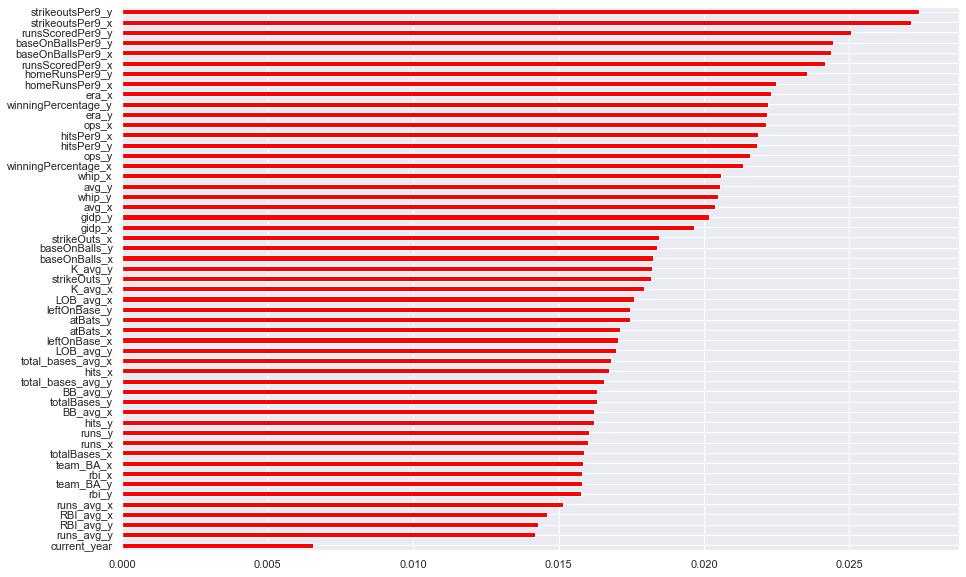

In [46]:
# Generating feature importance from prior year team offensive stats as well as starting pitchers stats
plot_features_importance(rf, "red")

## Adding a rolling 3-day & 7-day average for teams:
- Batting averages ( sum(Hits) / sum(AtBats) )
    - DONE!!! 
- LOB averages ( sum(LOB) / sum(AtBats + BB + IBB + HBP) ) # denom is sum of plate appearances
    - Holding off for now...
- Run averages ( sum(runs) / 7-games )
    - DONE!!!
- OBP averages ( sum(Hits + BB + IBB + HBP) / sum(AtBats + BB + IBB + HBP) ) # denom is sum of plate appearances
    - DONE!!!

## Create Home & Away OBP stats

In [47]:
game_df['Visitor_OBP'] = round((game_df['VisitorH'] + game_df['VisitorHBP'] + game_df['VisitorIBB'] + game_df['VisitorBB']) / (game_df['VisitorAB'] + game_df['VisitorHBP'] + game_df['VisitorIBB'] + game_df['VisitorBB']), 3)
game_df['Home_OBP'] = round((game_df['HomeH'] + game_df['HomeHBP'] + game_df['HomeIBB'] + game_df['HomeBB']) / (game_df['HomeAB'] + game_df['HomeHBP'] + game_df['HomeIBB'] + game_df['HomeBB']), 3)

## Create Home & Away 3d & 7d OBP trends

In [48]:
game_df['3d_homeOBP_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_OBP'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homeOBP_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_OBP'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorOBP_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_OBP'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorOBP_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_OBP'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

## Create Home & Away 3d & 7d scoring trends

In [49]:
game_df['3d_homescore_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['HomeRunsScore'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homescore_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['HomeRunsScore'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorscore_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['VisitorRunsScored'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorscore_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['VisitorRunsScored'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

## Create Home & Away 3d & 7d Batting Average trends

In [50]:
game_df['3d_homeBA'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_BA'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homeBA'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_BA'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorBA'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_BA'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorBA'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_BA'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

#### Seems like everything worked... now to train and test different models with the additional engineered features

In [51]:
# Created a 2nd drop_lst2 to take out additional columns that were created for previous modeling
drop_lst = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year',
'Visitor_OBP',
'Home_OBP',
'winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
'BB_avg_y', 'rbi_y', 'RBI_avg_y', ]

In [52]:
three_day_trends = ['3d_homeOBP_avg', '3d_visitorOBP_avg', '3d_homescore_avg', '3d_visitorscore_avg', '3d_homeBA', '3d_visitorBA']

In [53]:
seven_day_trends = ['7d_homeOBP_avg','7d_visitorOBP_avg','7d_homescore_avg','7d_visitorscore_avg','7d_homeBA','7d_visitorBA']

## Test on 3d trends first

In [54]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst, axis=1)
X = X.drop(seven_day_trends, axis=1)

In [55]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [56]:
X_train.columns

Index(['current_year', '3d_homeOBP_avg', '3d_visitorOBP_avg',
       '3d_homescore_avg', '3d_visitorscore_avg', '3d_homeBA', '3d_visitorBA'],
      dtype='object')

In [57]:
rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)

In [58]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,847,1444
True,939,1630


In [59]:
print(f"Accuracy for 3d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for 3d trends: 50.97%


In [60]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf2, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 51.04%


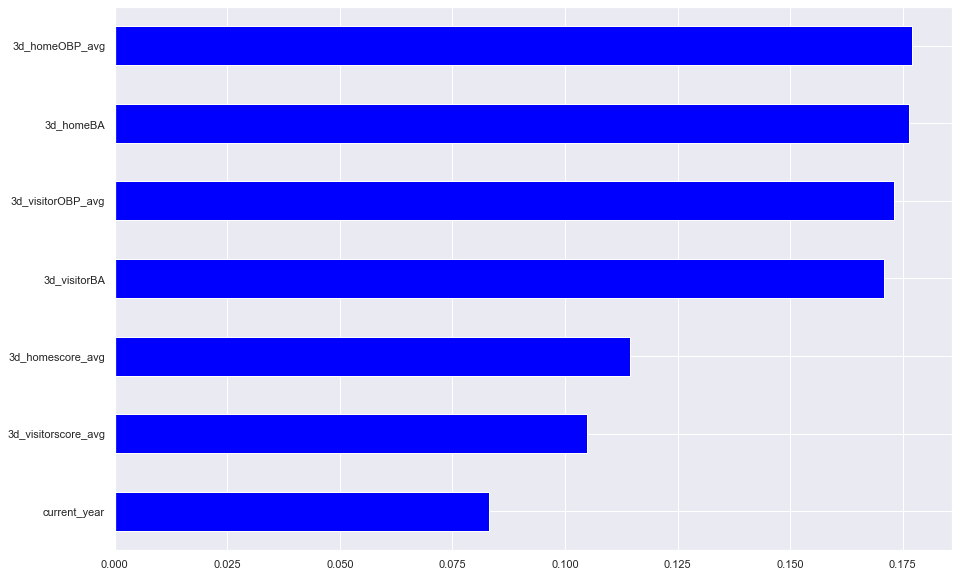

In [61]:
plot_features_importance(rf2, "blue")

## Now test 7d trends

In [62]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst, axis=1)
X = X.drop(three_day_trends, axis=1)

In [63]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [64]:
X_train.columns

Index(['current_year', '7d_homeOBP_avg', '7d_visitorOBP_avg',
       '7d_homescore_avg', '7d_visitorscore_avg', '7d_homeBA', '7d_visitorBA'],
      dtype='object')

In [65]:
rf2_7 = RandomForestClassifier()
rf2_7.fit(X_train, y_train)
y_pred = rf2_7.predict(X_test)

In [66]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,779,1512
True,942,1627


In [67]:
print(f"Accuracy for 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for 7d trends: 49.51%


In [68]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf2_7, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 51.3%


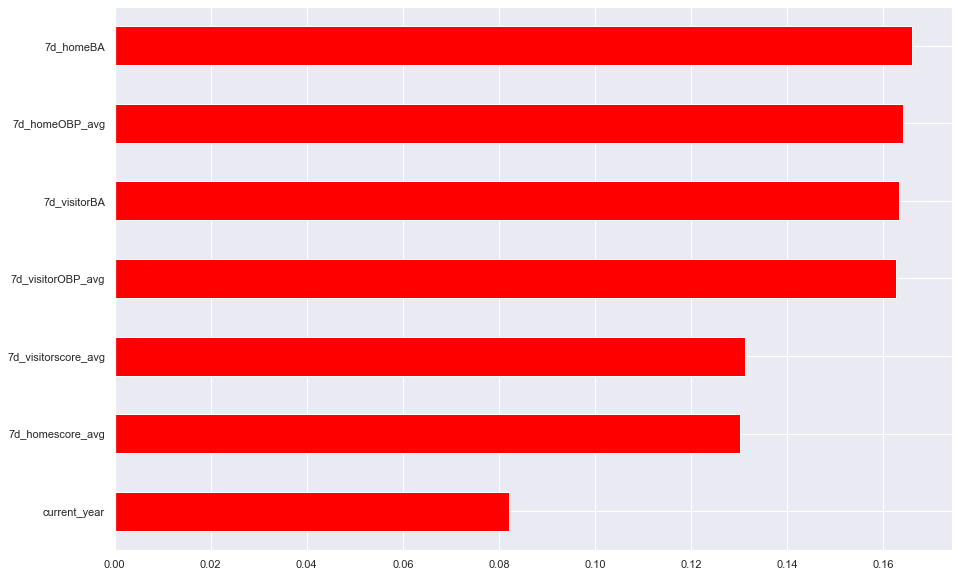

In [69]:
plot_features_importance(rf2_7, "red")

### It seemed like the 3d trends barely inched out the 7d trends by a fraction of a percent
### Going to try and model with:
    - historic trends & 3d
    - historic trends & 7d
    - historic trends with 3d & 7d trends

### Will train a RandomForest model on historitc team stats, 3d, and 7d trends.

In [70]:
# More or less the same features being dropped from before but adding 2 new features added to the game_df
new_drop_lst = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year',
'Visitor_OBP',
'Home_OBP']

### Will leverage 3d trends first...

In [71]:
y = game_df['Home_team_won?']
# Drop usual features
X = game_df.drop(new_drop_lst, axis=1)
# Dropping the seven day trends
X = X.drop(seven_day_trends, axis=1)

In [72]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [73]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
       'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
       'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
       'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year', '3d_homeOBP_avg',
       '3d_visitorOBP_avg', '3d_homescore_avg', '3d_visitorscore_avg',
       '3d_homeBA', '3d_visitorBA'],
      dtype='object')

In [74]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [75]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,940,1351
True,809,1760


In [76]:
print(f"Accuracy for historic + 3d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 3d trends: 55.56%


In [77]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 52.91%


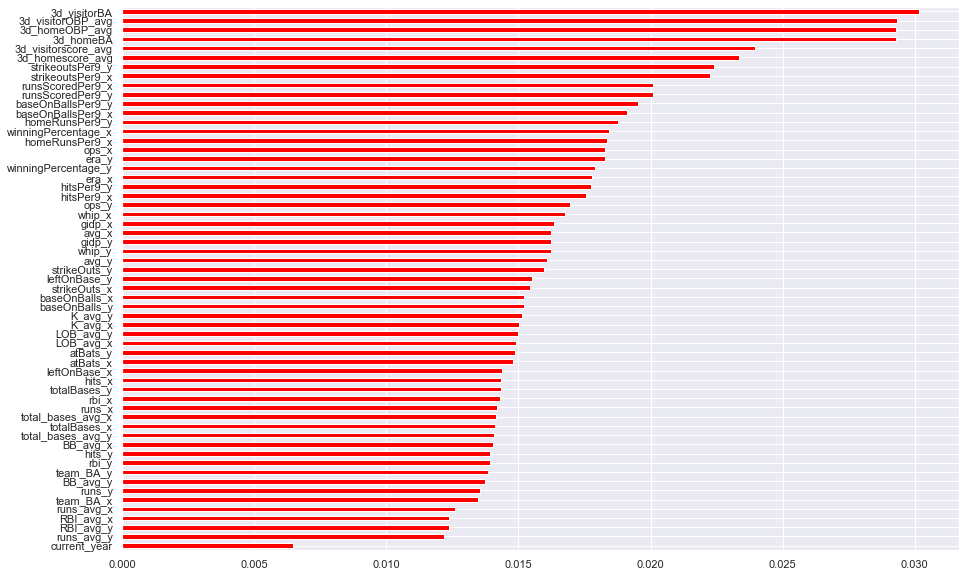

In [78]:
plot_features_importance(rf, "red")

### Now leverage 7d trends

In [79]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst, axis=1)
X = X.drop(three_day_trends, axis=1)

In [80]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [81]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
       'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
       'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
       'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year', '7d_homeOBP_avg',
       '7d_visitorOBP_avg', '7d_homescore_avg', '7d_visitorscore_avg',
       '7d_homeBA', '7d_visitorBA'],
      dtype='object')

In [82]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [83]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,905,1386
True,756,1813


In [84]:
print(f"Accuracy for historic + 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 7d trends: 55.93%


In [85]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 53.05%


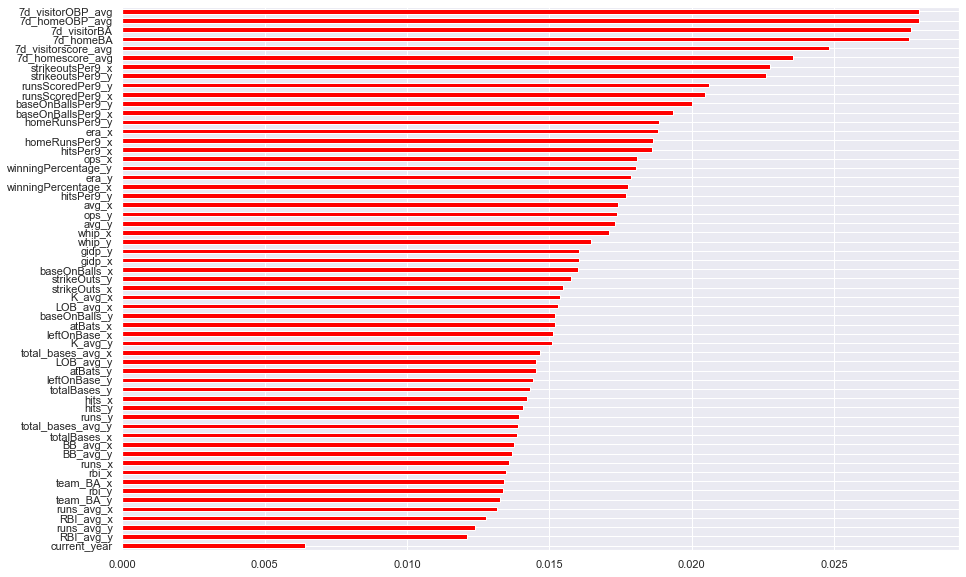

In [86]:
plot_features_importance(rf, "red")

## Now, model with historic, 3d, and 7d trends...

In [87]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst, axis=1)

In [88]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [89]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
       'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
       'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
       'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year', '3d_homeOBP_avg',
       '7d_homeOBP_avg', '3d_visitorOBP_avg', '7d_visitorOBP_avg',
       '3d_homescore_avg', '7d_homescore_avg', '3d_visitorscore_avg',
       '7d_vi

In [90]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [91]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,False,True
Actual Result,,
False,947,1344
True,829,1740


In [92]:
print(f"Accuracy for historic + 3d + 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 3d + 7d trends: 55.29%


In [93]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(rf, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 53.69%


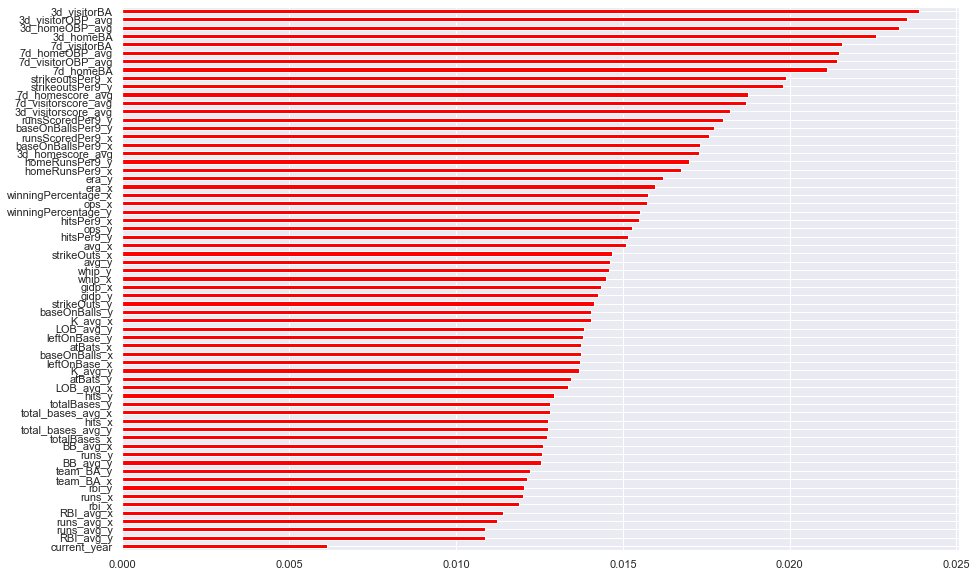

In [94]:
plot_features_importance(rf, "red")

# RandomForestClassifier seems to be working well with the new features that were added. Going to try out other models for comaprisons
- GradientBoostingClassifier
- AdaBoostClassifier

## Create a Train/Test split for the new models to leverage

In [95]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2017)

In [96]:
X_train.columns

Index(['winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
       'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
       'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
       'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
       'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
       'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
       'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
       'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
       'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
       'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
       'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
       'BB_avg_y', 'rbi_y', 'RBI_avg_y', 'current_year', '3d_homeOBP_avg',
       '7d_homeOBP_avg', '3d_visitorOBP_avg', '7d_visitorOBP_avg',
       '3d_homescore_avg', '7d_homescore_avg', '3d_visitorscore_avg',
       '7d_vi

## GradientBoostingClassifier with GridSearchCV

In [97]:
gbc = GradientBoostingClassifier()

In [98]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [99]:
params_dict = {'learning_rate': [.0001, .001, .01, .1],
               'n_estimators': [100,200,300,400,500,600,700]}

In [100]:
grid_gbc = GridSearchCV(gbc, param_grid=params_dict, scoring='accuracy', cv=5, n_jobs=-1)

In [101]:
grid_gbc.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
best_param = grid_gbc.best_params_

In [ ]:
best_cv_score = grid_gbc.best_score_

In [ ]:
best_model = grid_gbc.best_estimator_

In [ ]:
text_acc = best_model.score(X_test, y_test)
print(f"GradientBoosted with GridSearchCV accuracy: {round((text_acc*100),2)}%")

In [ ]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(grid_gbc, X_train, y_train, cv=5))*100, 2)}%")

## OOB GradientBoostingClassifier

In [ ]:
gbc.fit(X_train, y_train)

In [ ]:
y_pred = gbc.predict(X_test)

In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [ ]:
print(f"Accuracy for GradientBoosting (OOB): {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

In [ ]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gbc, X_train, y_train, cv=5))*100, 2)}%")

In [ ]:
plot_features_importance(gbc, "purple")

## AdaBoostClassifier

In [ ]:
abc = AdaBoostClassifier()

In [ ]:
abc.fit(X_train, y_train)

In [ ]:
y_pred = abc.predict(X_test)

In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [ ]:
print(f"Accuracy for Adaboost: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

In [ ]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(abc, X_train, y_train, cv=5))*100, 2)}%")

In [ ]:
plot_features_importance(gbc, "green")

## New Feature Engineering Ideas
- Pythagorean Expectation - (runs scored^2) / (runs scored^2 + runs allowed^2)
- winning % against a team